<a href="https://colab.research.google.com/github/Rakshit-Sawarn-iitb/Sign-detect/blob/main/SignCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the custom preprocessing functions
def grayscale(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

def denoising(gray_image):
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)
    return denoised_image

def thresholding(denoised_image):
    ret, thresholded_image = cv2.threshold(denoised_image, 127, 255, cv2.THRESH_BINARY)
    return thresholded_image

def resize(thresholded_image):
    resized_image = cv2.resize(thresholded_image, (256, 256))
    return resized_image

def preprocess(image):
    gray_image = grayscale(image)
    denoised_image = denoising(gray_image)
    thresholded_image = thresholding(denoised_image)
    resized_image = resize(thresholded_image)
    return resized_image

def load_images(file_paths, label):
    images = []
    labels = []
    for file in file_paths:
        img = cv2.imread(file)
        if img is not None:
            img = preprocess(img)
            images.append(img)
            labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Specify the directories containing the images
org_dir = '/content/drive/My Drive/full_org'
forg_dir = '/content/drive/My Drive/full_forg'

# List the image files
original_files = [os.path.join(org_dir, f) for f in os.listdir(org_dir) if f.endswith('.png')]
forged_files = [os.path.join(forg_dir, f) for f in os.listdir(forg_dir) if f.endswith('.png')]

print(f"Original signatures: {len(original_files)}")
print(f"Forged signatures: {len(forged_files)}")

# Load original and forged images
original_images, original_labels = load_images(original_files, 0)  # Label 0 for original
forged_images, forged_labels = load_images(forged_files, 1)  # Label 1 for forged

# Combine and split the dataset
X = np.concatenate((original_images, forged_images), axis=0)
y = np.concatenate((original_labels, forged_labels), axis=0)

# Normalize the images
X = X / 255.0
X = X.reshape(-1, 256, 256, 1)  # Reshape for the model

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the numpy arrays for later use
np.save('/content/X_train.npy', X_train)
np.save('/content/X_test.npy', X_test)
np.save('/content/y_train.npy', y_train)
np.save('/content/y_test.npy', y_test)

# Load the numpy arrays
X_train = np.load('/content/X_train.npy')
X_test = np.load('/content/X_test.npy')
y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

class SignatureDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change shape to [channels, height, width]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Create dataset objects
train_dataset = SignatureDataset(X_train, y_train)
test_dataset = SignatureDataset(X_test, y_test)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original signatures: 1327
Forged signatures: 1320


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        labels = labels.float().view(-1, 1)  # Reshape labels for binary classification
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        labels = labels.float().view(-1, 1)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch [1/10], Loss: 0.6895
Epoch [2/10], Loss: 0.5321
Epoch [3/10], Loss: 0.4362
Epoch [4/10], Loss: 0.3298
Epoch [5/10], Loss: 0.2601
Epoch [6/10], Loss: 0.1949
Epoch [7/10], Loss: 0.1732
Epoch [8/10], Loss: 0.1185
Epoch [9/10], Loss: 0.0922
Epoch [10/10], Loss: 0.0778
Test Accuracy: 86.42%


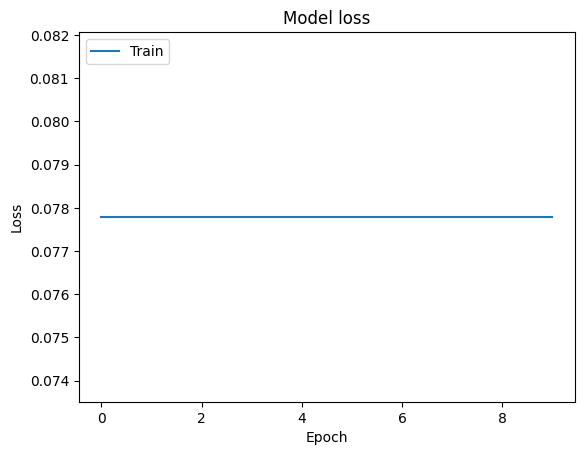

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot([running_loss / len(train_dataloader) for _ in range(num_epochs)])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


In [20]:
path = '/content/drive/MyDrive/your_model.pth'

# Save the state dictionary of the model
torch.save(model.state_dict(), path)

print(f"Model saved to {path}")

Model saved to /content/drive/MyDrive/your_model.pth


In [21]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        labels = labels.float().view(-1, 1)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 86.42%


In [22]:
from PIL import Image
import cv2
import numpy as np
import random
from torchvision.transforms import functional as TF

def preprocess(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)
    ret, thresholded_image = cv2.threshold(denoised_image, 127, 255, cv2.THRESH_BINARY)
    resized_image = cv2.resize(thresholded_image, (256, 256))
    return resized_image

def augment_image(image):
    image = Image.fromarray(image)
    augmented_images = []
    for _ in range(20):  # Create 20 augmentations
        aug_img = TF.adjust_brightness(image, random.uniform(0.7, 1.3))
        aug_img = TF.adjust_contrast(aug_img, random.uniform(0.7, 1.3))
        if random.random() > 0.5:
            aug_img = TF.hflip(aug_img)
        if random.random() > 0.5:
            aug_img = TF.vflip(aug_img)
        augmented_images.append(np.array(aug_img))
    return augmented_images

# Load your new signature
new_signature_path = '/content/drive/MyDrive/original.png'
new_signature = cv2.imread(new_signature_path)
preprocessed_signature = preprocess(new_signature)
augmented_signatures = augment_image(preprocessed_signature)

# Create a dataset for fine-tuning
class FineTuneDataset(Dataset):
    def __init__(self, images, label):
        self.images = images
        self.label = label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize and add channel dimension
        label = torch.tensor(self.label, dtype=torch.float32).unsqueeze(0)
        return image, label

fine_tune_dataset = FineTuneDataset(augmented_signatures, 0)  # Label 0 for your signature
fine_tune_dataloader = DataLoader(fine_tune_dataset, batch_size=4, shuffle=True)


In [23]:
# Fine-tune the model
model = CNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/your_model.pth'))
model.eval()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_finetune_epochs = 5
model.train()
for epoch in range(num_finetune_epochs):
    running_loss = 0.0
    for images, labels in fine_tune_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Fine-tune Epoch [{epoch+1}/{num_finetune_epochs}], Loss: {running_loss/len(fine_tune_dataloader):.4f}')

# Save the fine-tuned model



Fine-tune Epoch [1/5], Loss: 1.6779
Fine-tune Epoch [2/5], Loss: 0.9022
Fine-tune Epoch [3/5], Loss: 0.4011
Fine-tune Epoch [4/5], Loss: 0.2446
Fine-tune Epoch [5/5], Loss: 0.0866


In [24]:
torch.save(model.state_dict(), '/content/drive/MyDrive/fine_model.pth')

In [33]:
# Load the fine-tuned model
model = CNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/fine_model.pth'))
model.eval()

def classify_signature(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or cannot be opened.")
    img = preprocess(img)
    img = img / 255.0  # Normalize
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Reshape to [1, 1, 256, 256]
    with torch.no_grad():
        output = model(img)
        print(output)
        predicted = (output > 0.1).float().item()
        if predicted == 0:
            return "Signature is not yours."
        else:
            return "Signature is yours."

# Test the function with a new signature
new_signature_path = '/content/drive/MyDrive/forged.png'
result = classify_signature(new_signature_path)
print(result)


tensor([[0.0007]])
Signature is not yours.
